# Import all Necessary Libraries

In [13]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import keras
from keras.models import Sequential
from keras.layers import Conv2D, Lambda, MaxPooling2D # convolution layers
from keras.layers import Dense, Dropout, Flatten # core layers
from keras.layers.experimental import SyncBatchNormalization

from keras.preprocessing.image import ImageDataGenerator

from keras.utils import to_categorical

# Data preparation

In [137]:
from keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [138]:
x_train = x_train / 255.0
x_test = x_test / 255.0

## Reshape

In [139]:
# Reshape image in 3 dimensions (RGB) (height = 32px, width = 32px , channels = 3)
x_train = x_train.reshape(-1,32,32,3)

## Label encoding

**One-Hot Encoding**

In [140]:
# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
y_test = to_categorical(y_test)
y_train = to_categorical(y_train)
print(f"Label size {y.shape}")

Label size (50000, 10)


## Split training and valdiation set

In [141]:
# Split the train and the validation set for the fitting
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

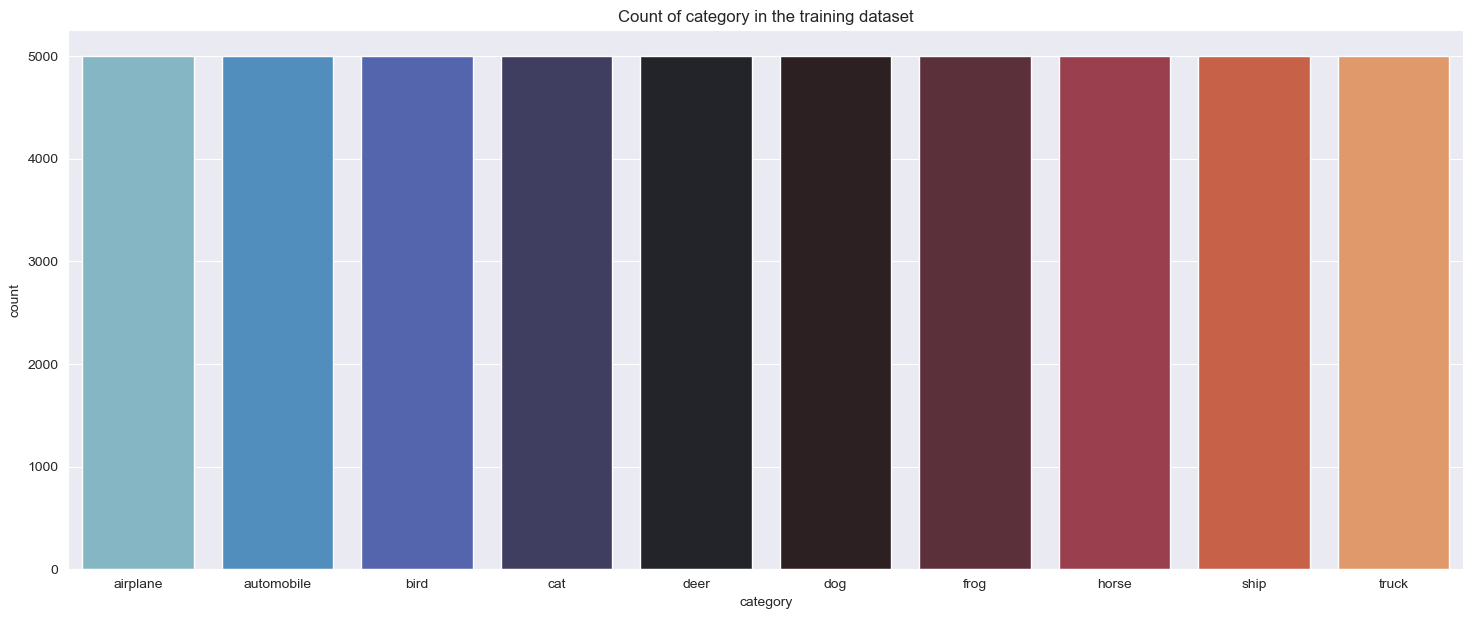

In [142]:
y_pd = pd.DataFrame(y_train)
y_pd_plot = pd.DataFrame(y_pd.value_counts(),columns=["count"]).sort_index()
y_pd_plot['category'] = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
# print(y_pd_plot)
fig, ax = plt.subplots(figsize = (18,7))
ax.set_title("Count of category in the training dataset")
sns.barplot(data=y_pd_plot, y='count', x='category', palette="icefire")
plt.show()

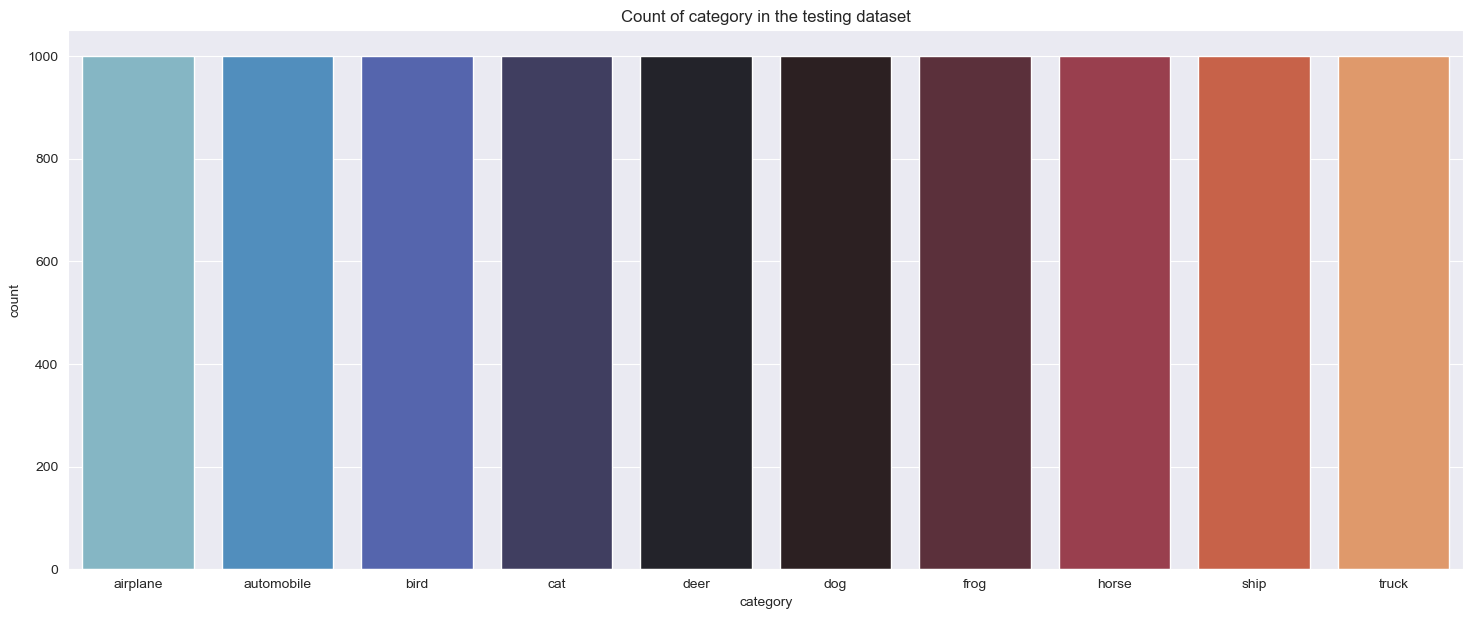

In [143]:
y_pd = pd.DataFrame(y_test)
y_pd_plot = pd.DataFrame(y_pd.value_counts(),columns=["count"]).sort_index()
y_pd_plot['category'] = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
# print(y_pd_plot)
fig, ax = plt.subplots(figsize = (18,7))
ax.set_title("Count of category in the testing dataset")
sns.barplot(data=y_pd_plot, y='count', x='category', palette="icefire")
plt.show()

In [144]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((50000, 32, 32, 3), (10000, 32, 32, 3), (50000, 10), (10000, 10))

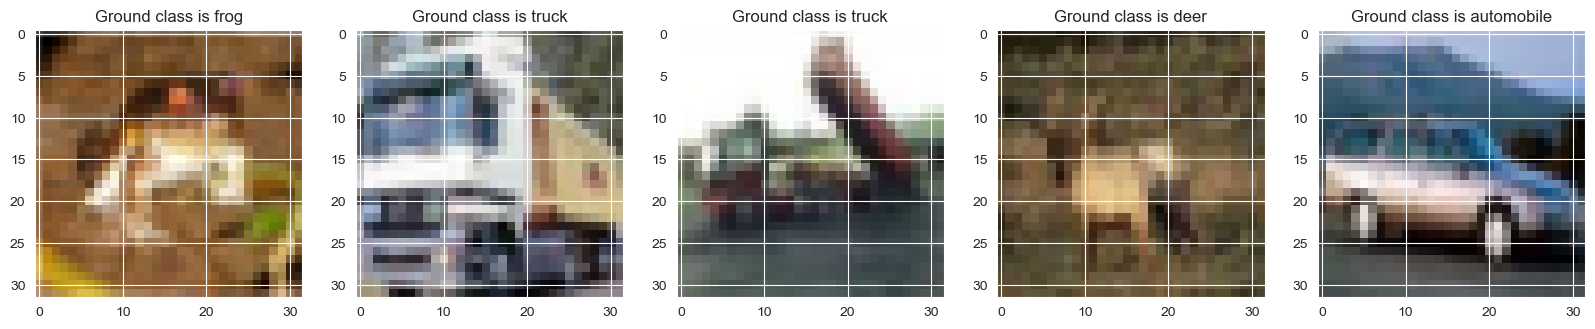

In [151]:
fig, axis = plt.subplots(1, 5, figsize=(20, 10))
arr = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
for i, ax in enumerate(axis.flat):
    ax.imshow(x_train[i], cmap='brg')
    category = arr[y_train[i].nonzero()[0][0]]
    ax.set(title = f"Ground class is {category}");

# Model Definition

In [164]:
from keras import layers
from keras.layers import Activation

model = Sequential([
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

In [165]:
model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_111 (Conv2D)         (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_53 (MaxPooli  (None, 15, 15, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_112 (Conv2D)         (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_54 (MaxPooli  (None, 6, 6, 64)          0         
 ng2D)                                                           
                                                                 
 flatten_13 (Flatten)        (None, 2304)              0         
                                                                 
 dense_26 (Dense)            (None, 64)              

## Data augmentation

In [155]:
# datagen = ImageDataGenerator(
#         featurewise_center=True,  # set input mean to 0 over the dataset
#         samplewise_center=True,  # set each sample mean to 0
#         featurewise_std_normalization=True,  # divide inputs by std of the dataset
#         samplewise_std_normalization=True,  # divide each input by its std
#         zca_whitening=False,  # apply ZCA whitening
#         zca_epsilon=1e-06,  # epsilon for ZCA whitening
#         rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
#         # randomly shift images horizontally (fraction of total width)
#         width_shift_range=0.1,
#         # randomly shift images vertically (fraction of total height)
#         height_shift_range=0.1,
#         shear_range=0.,  # set range for random shear
#         zoom_range=0.,  # set range for random zoom
#         channel_shift_range=0.,  # set range for random channel shifts
#         # set mode for filling points outside the input boundaries
#         fill_mode='nearest',
#         cval=0.,  # value used for fill_mode = "constant"
#         horizontal_flip=True,  # randomly flip images
#         vertical_flip=False,  # randomly flip images
#         # set rescaling factor (applied before any other transformation)
#         rescale=None,
#         # set function that will be applied on each input
#         preprocessing_function=None,
#         # image data format, either "channels_first" or "channels_last"
#         data_format=None,
#         # fraction of images reserved for validation (strictly between 0 and 1)
#         validation_split=0.0)
#
# datagen.fit(x_train)
# train_gen = datagen.flow(x_train, y_train, batch_size=128)
# test_gen = datagen.flow(x_test, y_test, batch_size=128)

In [166]:
es = keras.callbacks.EarlyStopping(
        monitor="accuracy", # metrics to monitor
        patience=10, # how many epochs before stop
        verbose=1,
        mode="max", # we need the maximum accuracy.
        restore_best_weights=True, #
     )

rp = keras.callbacks.ReduceLROnPlateau(
        monitor="accuracy",
        factor=0.2,
        patience=3,
        verbose=1,
        mode="max",
        min_lr=0.00001,
     )

epochs = 15
batch_size = 128
train_steps = x_train.shape[0] // batch_size
valid_steps = x_test.shape[0] // batch_size

In [167]:
# Let's train the model using adam
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [168]:
# Fit the model
history = model.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=epochs, callbacks=(es,rp))

Epoch 1/15
1563/1563 [==============================] - 38s 23ms/step - loss: 1.5112 - accuracy: 0.4566 - val_loss: 1.2731 - val_accuracy: 0.5567 - lr: 0.0010
Epoch 2/15
1563/1563 [==============================] - 33s 21ms/step - loss: 1.1559 - accuracy: 0.5937 - val_loss: 1.1509 - val_accuracy: 0.5976 - lr: 0.0010
Epoch 3/15
1563/1563 [==============================] - 33s 21ms/step - loss: 1.0249 - accuracy: 0.6418 - val_loss: 1.0529 - val_accuracy: 0.6255 - lr: 0.0010
Epoch 4/15
1563/1563 [==============================] - 36s 23ms/step - loss: 0.9454 - accuracy: 0.6715 - val_loss: 0.9874 - val_accuracy: 0.6602 - lr: 0.0010
Epoch 5/15
1563/1563 [==============================] - 35s 23ms/step - loss: 0.8819 - accuracy: 0.6950 - val_loss: 0.9426 - val_accuracy: 0.6763 - lr: 0.0010
Epoch 6/15
1563/1563 [==============================] - 35s 23ms/step - loss: 0.8324 - accuracy: 0.7100 - val_loss: 0.9178 - val_accuracy: 0.6784 - lr: 0.0010
Epoch 7/15
1563/1563 [========================

# Evaluate the model
## Training and validation curves

In [169]:
print(history.history)

{'loss': [1.511206865310669, 1.1559200286865234, 1.0249334573745728, 0.9454115629196167, 0.8818855285644531, 0.8324134349822998, 0.7887198328971863, 0.7545524835586548, 0.7204237580299377, 0.6876899003982544, 0.6574724912643433, 0.6315454840660095, 0.6071704626083374, 0.5841811895370483, 0.5609402656555176], 'accuracy': [0.4565599858760834, 0.5936999917030334, 0.6418200135231018, 0.6715199947357178, 0.6949599981307983, 0.7099599838256836, 0.7257000207901001, 0.7368599772453308, 0.7492200136184692, 0.7604799866676331, 0.7702400088310242, 0.7787600159645081, 0.7873600125312805, 0.7936000227928162, 0.8024600148200989], 'val_loss': [1.273085594177246, 1.1508586406707764, 1.0528531074523926, 0.9874183535575867, 0.9425604343414307, 0.9177539944648743, 0.9187992215156555, 0.9239004850387573, 0.9200731515884399, 0.9039505124092102, 0.9149095416069031, 0.9129522442817688, 0.9388206005096436, 0.9541470408439636, 0.9434171915054321], 'val_accuracy': [0.5566999912261963, 0.597599983215332, 0.62550

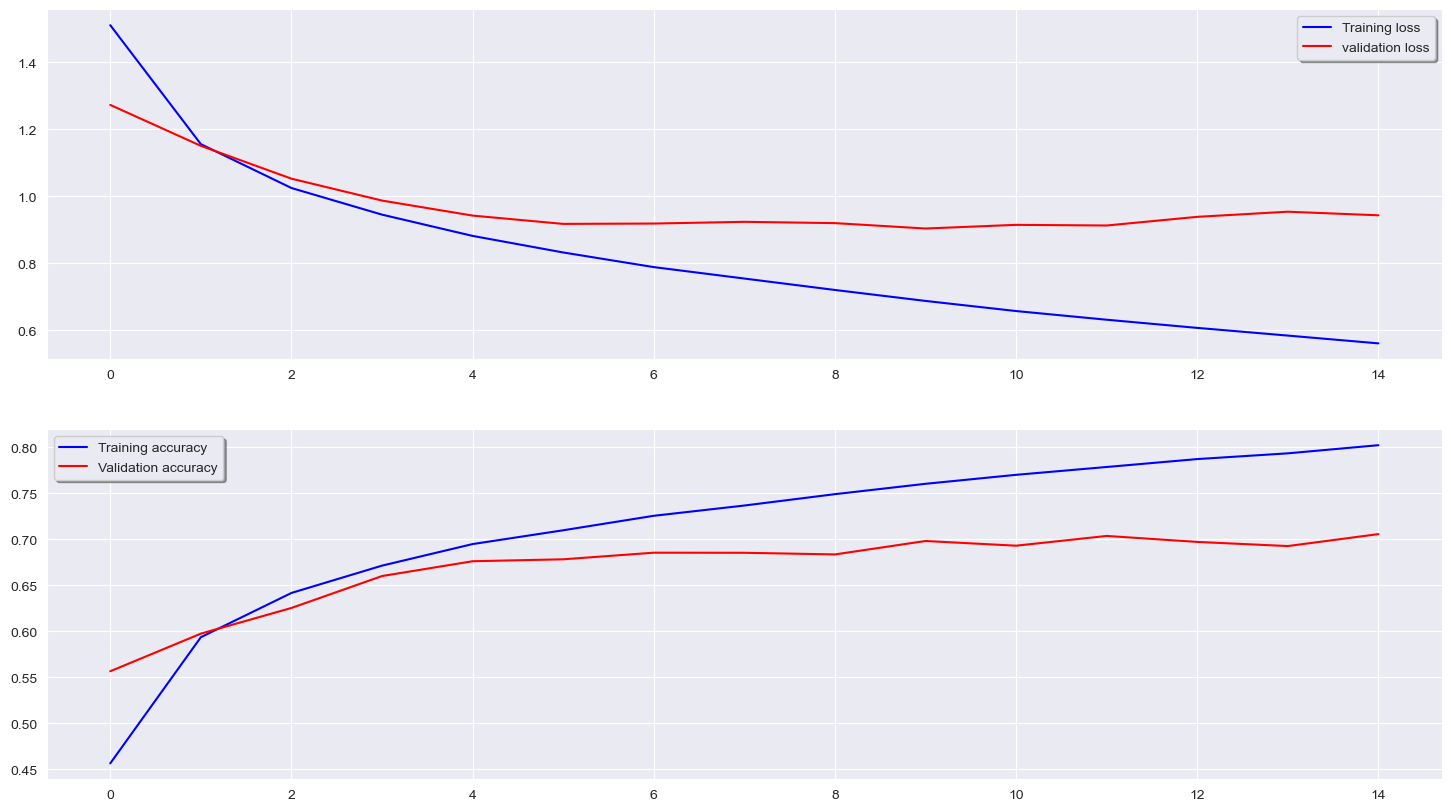

In [170]:
# Plot the loss and accuracy curves for training and validation
fig, ax = plt.subplots(2,1, figsize=(18, 10))
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

## Confusion matrix

313/313 [==============================] - 2s 8ms/step


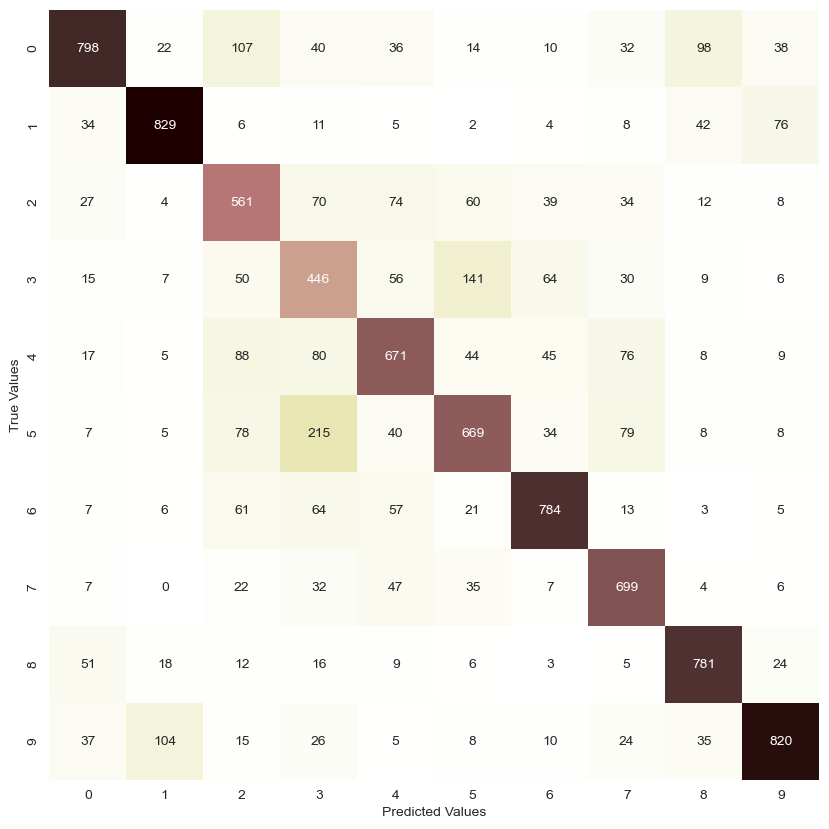

In [172]:
fig = plt.figure(figsize=(10, 10)) # Set Figure

y_pred = model.predict(x_test) # Predict class probabilities as 2 => [0.1, 0, 0.9, 0, 0, 0, 0, 0, 0, 0]

Y_pred = np.argmax(y_pred, 1) # Decode Predicted labels
Y_test = np.argmax(y_test, 1) # Decode labels

mat = confusion_matrix(Y_test, Y_pred) # Confusion matrix

# Plot Confusion matrix
sns.heatmap(mat.T, square=True, annot=True, cbar=False, cmap=plt.cm.pink_r, fmt='.0f')
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.show();

## Prediction validation results

## ROC Curve and AUC

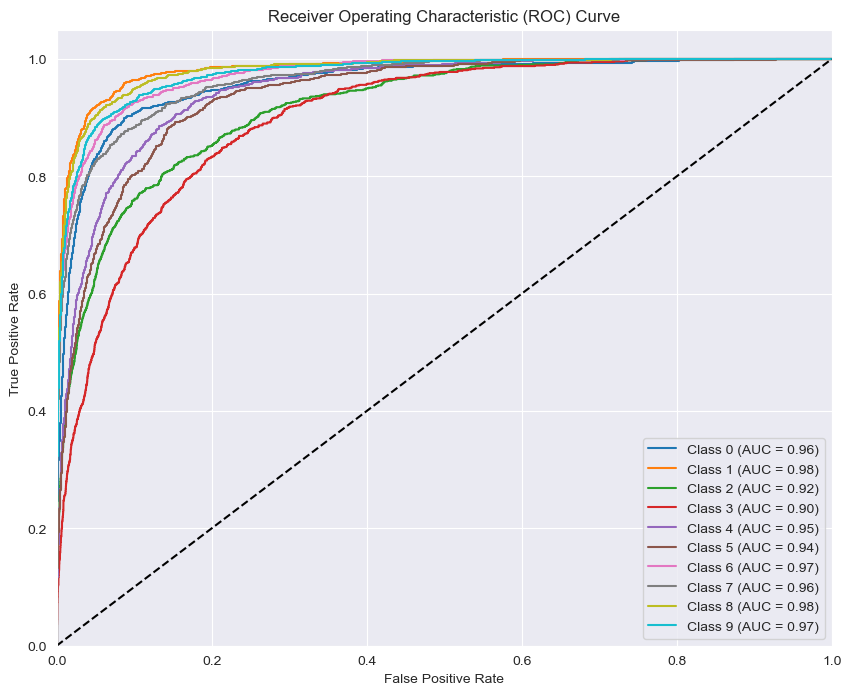

In [177]:
from sklearn.metrics import roc_curve, auc

# Compute class-wise ROC curve and AUC
n_classes = 10  # Number of classes
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curves
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()